In [1]:
import MDAnalysis as mda
import mdtraj as md
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
warnings.filterwarnings("ignore")

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
/usr/local/Caskroom/miniconda/base/envs/charm38/lib/python3.8/site-packages/MDAnalysis/coordinates/TRJ.py:1209: DeprecationWarning: Please use `netcdf_file` from the `scipy.io` namespace, the `scipy.io.netcdf` namespace is deprecated.
  class NCDFPicklable(scipy.io.netcdf.netcdf_file):


In [2]:
# plot parameters
%matplotlib inline
plt.rcParams['axes.labelpad'] = 3.
plt.rcParams['font.size'] = 25
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 10
plt.rcParams['legend.fontsize'] = 25
plt.rcParams['text.usetex'] = False
plt.rcParams['font.family'] = "serif"
plt.rcParams['font.serif'] = "cm"
plt.rcParams['figure.autolayout'] = False
pltcolors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Context
This notebook is distributed as part of the article:

**Turning Up the Heat Mimics Allosteric Signaling in Imidazole-Glycerol Phosphate Synthase.**

by *Federica Maschietto, Uriel N. Morzan, Florentina Tofoleanu, Aria Gheeraert, Apala Chaudhuri, Gregory W. Kyro, Peter Nekrasov, Bernard Brooks, J. Patrick Loria, Ivan Rivalta, Victor S. Batista*


The following analysis can be used to reproduce the Secondary Structure persistency analysis as described in the article (Figure 3,D). The secondary structure (SSE) persistency, is defined in the following as the percentage of trajectory frames in which each residue retains the same secondary structure state as in the first frame of the trajectory, which is the same as found in crystal structure of IGPS from Termotoga maritima (PDBID: 1GPW).



In [1]:
# CHANGE PATH ACCORDINGLY:
# trajectories can be downloaded at the following link:
# https://drive.google.com/drive/folders/1yc5vzhWw_NZ_C34QfC34-JpArE8SUKIV?usp=sharing

# change to the appropriate /path/to/drive/
p2d = '.'


path =  p2d + '/TRAJECTORIES/'

# path to output directory, change accordingly
figpath = './'


In [8]:
# auxiliary functions

def normalize_array(arr0):
    """normalize between -1 and 1"""
    arr = arr0.copy()
    mini = np.min(arr)
    maxi = np.max(arr)
    n =  2*((arr - mini) / (maxi - mini)) -1
    return n

def normarray(arr0):
    """normalize between 0 and 1"""
    arr = arr0.copy()
    mini = np.min(arr)
    maxi = np.max(arr)
    n = (arr - mini) / (maxi - mini)
    return n




In [9]:
# load APO30 trajectory
t30a = path + '30A-stride50.dcd'
# load APO50 trajectory
t50a = path + '50A-stride50.dcd'
# load HOLO30 trajectory
t30h = path + '30H-stride50.dcd'

#load trajectories using mdtraj
pdbholo = path + '30H_frame0.pdb'
pdbapo30 = path + '30A_frame0.pdb'
pdbapo50 = path + '50A_frame0.pdb'

ut30h = md.load(t30h, top=pdbholo)
ut30a = md.load(t30a, top=pdbapo30)
ut50a = md.load(t50a, top=pdbapo50)

# assign apo30 as reference
ut30r = md.load(t30a, top=pdbapo30)


In [10]:
# store trajectory files for apo t50a t30a t30h in universes

# select protein atoms
selection_t30a = ut30a.top.select('protein and (resid 0 to 252)')
selection_t30h = ut30h.top.select('protein and (resid 0 to 252)')
selection_t50a = ut50a.top.select('protein and (resid 0 to 252)')
selection_ref  = ut30r.top.select('protein and (resid 0 to 252)')

# select protein atoms in topology
topo_t30a = ut30a.top.subset(selection_t30a)
topo_t30h = ut30h.top.subset(selection_t30h)
topo_t50a = ut50a.top.subset(selection_t50a)
topo_ref  = ut30r.top.subset(selection_ref )

# define positions
positions_t30a = ut30a.xyz[:, selection_t30a]
positions_t30h = ut30h.xyz[:, selection_t30h]
positions_t50a = ut50a.xyz[:, selection_t50a]

# reference is frame0
positions_ref  = ut30r.xyz[0, selection_ref ]

# define trajectory from positions and topology of protein atoms
traj_t30a = md.Trajectory(positions_t30a, topo_t30a)
traj_t30h = md.Trajectory(positions_t30h, topo_t30h)
traj_t50a = md.Trajectory(positions_t50a, topo_t50a)
traj_ref  = md.Trajectory(positions_ref , topo_ref )

In [11]:
# compute and store DSSPs
dssp_t30a  = md.compute_dssp(traj_t30a )
dssp_t30h  = md.compute_dssp(traj_t30h )
dssp_t50a  = md.compute_dssp(traj_t50a )
dssp_ref   = md.compute_dssp(traj_ref  )


In [12]:
# reduce DSSP nomenclature to either 'helix', 'coil' or 'strand'
sec_struct_codes = {0 : "I",
                    1 : "S",
                    2 : "H",
                    3 : "E",
                    4 : "G",
                    5 : "B",
                    6 : "T",
                    7 : "C"}
# Converter for the DSSP secondary structure elements
dssp_to_abc = {"I" : "helix",
               "S" : "coil",
               "H" : "helix",
               "E" : "strand",
               "G" : "helix",
               "B" : "strand",
               "T" : "coil",
               "C" : "coil",
               'NA': "na"}
t=0
sse_t30a = np.array([dssp_to_abc[ss] for ss in dssp_t30a[t] for t in range(len(dssp_t30a))], dtype="U1").reshape(dssp_t30a.shape)
sse_t30h = np.array([dssp_to_abc[ss] for ss in dssp_t30h[t] for t in range(len(dssp_t30h))], dtype="U1").reshape(dssp_t30h.shape)
sse_t50a = np.array([dssp_to_abc[ss] for ss in dssp_t50a[t] for t in range(len(dssp_t50a))], dtype="U1").reshape(dssp_t50a.shape)
 


In [13]:
# store secondary structure assignments for each trajectory
sse_t30a_0 = np.array([dssp_to_abc[ss] for ss in dssp_t30a[0]])
sse_t30h_0 = np.array([dssp_to_abc[ss] for ss in dssp_t30h[0]])
sse_t50a_0 = np.array([dssp_to_abc[ss] for ss in dssp_t50a[0]])

# # and for the reference
# sse_ref     = np.array([dssp_to_abc[ss] for ss in dssp_ref[0]], dtype="U1")

In [14]:
df_t30a = pd.DataFrame(sse_t30a)
df_t30h = pd.DataFrame(sse_t30h)
df_t50a = pd.DataFrame(sse_t50a)



In [15]:
# abbreviate elements and count occurrences
abbreviation = {'h': 'helix',
            'c': 'coil',
            's': 'strand',
            }

# Compute secondary structure persistency
## APO30

In [16]:
# index blocks of secondary elements for t30a
blocks_t30a = {}
count_t30a = 1
sublock_t30a = []
for i in range(0, len(sse_t30a_0)):
    if sse_t30a_0[i] == sse_t30a_0[i-1]:
        if i == 1:
            sublock_t30a.append(sse_t30a_0[0])
            sublock_t30a.append(sse_t30a_0[i])
        elif i > 1:
            sublock_t30a.append(sse_t30a_0[i])
        blocks_t30a.update({count_t30a:sublock_t30a})
    else:
        count_t30a +=1
        sublock_t30a = []
        sublock_t30a.append(sse_t30a_0[i])
        blocks_t30a.update({count_t30a:sublock_t30a})
#blocks_t30a

In [17]:
# count occurrences for t30a 
count_a = 0
count_b = 0
count_c = 0
names_t30a = []
for i,n in enumerate(blocks_t30a.values()):
    if 'h' in n:
        #print('h@>',n)
        count_a += 1
        names_t30a.append(abbreviation[n[0]]+str(count_a))
    elif 'c' in n:
        #print('c@>', n)
        count_b += 1
        names_t30a.append(abbreviation[n[0]]+str(count_b))
    elif 's' in n:
        #print('s@>',n)
        count_c += 1
        names_t30a.append(abbreviation[n[0]]+str(count_c))

##  HOLO30

In [18]:
# count elements for t30h
blocks_t30h = {}
count_t30h = 1
sublock_t30h = []
for i in range(0, len(sse_t30h_0)):
    if sse_t30h_0[i] == sse_t30h_0[i-1]:
        if i == 1:
            sublock_t30h.append(sse_t30h_0[0])
            sublock_t30h.append(sse_t30h_0[i])
        elif i > 1:
            sublock_t30h.append(sse_t30h_0[i])
        blocks_t30h.update({count_t30h:sublock_t30h})
    else:
        count_t30h +=1
        sublock_t30h = []
        sublock_t30h.append(sse_t30h_0[i])
        blocks_t30h.update({count_t30h:sublock_t30h})
        

In [19]:
# count occurrences for t30h 
count_a = 0
count_b = 0
count_c = 0
names_t30h = []
for i,n in enumerate(blocks_t30h.values()):
    if 'h' in n:
        #print('h@>',n)
        count_a += 1
        names_t30h.append(abbreviation[n[0]]+str(count_a))
    elif 'c' in n:
        #print('c@>', n)
        count_b += 1
        names_t30h.append(abbreviation[n[0]]+str(count_b))
    elif 's' in n:
        #print('s@>',n)
        count_c += 1
        names_t30h.append(abbreviation[n[0]]+str(count_c))

## APO50

In [20]:
# count elements for t50a 
blocks_t50a = {}
count_t50a = 1
sublock_t50a = []
for i in range(0, len(sse_t50a_0)):
    if sse_t50a_0[i] == sse_t50a_0[i-1]:
        if i == 1:
            sublock_t50a.append(sse_t50a_0[0])
            sublock_t50a.append(sse_t50a_0[i])
        elif i > 1:
            sublock_t50a.append(sse_t50a_0[i])
        blocks_t50a.update({count_t50a:sublock_t50a})
    else:
        count_t50a +=1
        sublock_t50a = []
        sublock_t50a.append(sse_t50a_0[i])
        blocks_t50a.update({count_t50a:sublock_t50a})

In [21]:
# count occurrences for t50a 
count_a = 0
count_b = 0
count_c = 0
names_t50a = []
for i,n in enumerate(blocks_t50a.values()):
    if 'h' in n:
        #print('h@>',n)
        count_a += 1
        names_t50a.append(abbreviation[n[0]]+str(count_a))
    elif 'c' in n:
        #print('c@>', n)
        count_b += 1
        names_t50a.append(abbreviation[n[0]]+str(count_b))
    elif 's' in n:
        #print('s@>',n)
        count_c += 1
        names_t50a.append(abbreviation[n[0]]+str(count_c))

In [22]:
# create dictionary of elements for t30a t50a t30h
ssdict_t30a = dict(zip(names_t30a, blocks_t30a.values()))
ssdict_t30h = dict(zip(names_t30h, blocks_t30h.values()))
ssdict_t50a = dict(zip(names_t50a, blocks_t50a.values()))

# create dataframe and replcae letter with either 'helix', 'coil', or strand for t30a 
df_t30a = pd.DataFrame(dssp_t30a.T)
for letter in dssp_to_abc.keys():
    df_t30a = df_t30a.replace({letter : dssp_to_abc[letter]})

# create dataframe and replcae letter with either 'helix', 'coil', or strand for t30h 
df_t30h = pd.DataFrame(dssp_t30h.T)
for letter in dssp_to_abc.keys():
    df_t30h = df_t30h.replace({letter : dssp_to_abc[letter]})
    
# create dataframe and replcae letter with either 'helix', 'coil', or strand for t50a
df_t50a= pd.DataFrame(dssp_t50a.T)
for letter in dssp_to_abc.keys():
    df_t50a= df_t50a.replace({letter : dssp_to_abc[letter]})    
    
    
    

In [23]:
# Experimental data (for reproducing figures in SI)

# df_CAexp = pd.read_csv(path + 'EXPERIMENTAL/CAapo_holo_50C.csv')

# df_CAexp = df_CAexp[df_CAexp.columns[[0,1,2,4,6,8]].values]

# # store CA experimental shifts that are assigned in both apo30 and apo50 experimente in Is_assigned column
# df_CAexp['Is_assigned']= np.asarray(np.mean([df_CAexp['Is_assigned_30'].values, df_CAexp['Is_assigned_50'].values], axis=0), dtype=int)


# # # EXPERIMENTAL DIFFERENCE CA SHIFTS, betwern t50a and t30a
# df_CAexp = df_CAexp[df_CAexp['Is_assigned'] == 1]

# CAexp_t50a = df_CAexp['CA_50'].values#
# CAexp_t30a = df_CAexp['CA_30'].values

# CA_idx = np.asarray([int(res.strip(' ')[1:]) for res in df_CAexp['30C_HNCA'].values])-1
# #df_CAexp


#  Load and save experimental shifts to data frames

In [27]:
# PREDICTED SHIFTS
t30a_SX2 = pd.read_csv(path_shifts + 'PRED_SHIFTS/30_SX2-shifts.csv')
t50a_SX2 = pd.read_csv(path_shifts + 'PRED_SHIFTS/50_SX2-shifts.csv')
t30h_SX2 = pd.read_csv(path_shifts + 'PRED_SHIFTS/30H_SX2-shifts.csv')
#t30h_SX2 = pd.read_csv(path + 'PREDICTED_SHIFTS/IGPS-Holo_30_stride1_shifts.csv')


In [29]:
#offset =  0.43
offset =  0.
SX2_CA_t30a = t30a_SX2['Shift (CA)'].values-offset
SX2_CA_t50a = t50a_SX2['Shift (CA)'].values-offset
SX2_CA_t30h = t30h_SX2[t30h_SX2['ATOMNAME'] == 'CA']['AVERAGE'].values[0:253]-offset

SX2_CA_t30h_min_t30a = np.asarray(np.abs(SX2_CA_t30h - SX2_CA_t30a))
SX2_CA_t50a_min_t30a = np.asarray(np.abs(SX2_CA_t50a - SX2_CA_t30a))
SX2_CA_t50a_min_t30h = np.asarray(np.abs(SX2_CA_t50a - SX2_CA_t30h))

# normalize to fixed scale (concatenate then normalize then separate) 
norm_SX2_CA_t30h_min_t30a = normarray(np.concatenate([SX2_CA_t30h_min_t30a, SX2_CA_t50a_min_t30a]))[0:253]
norm_SX2_CA_t50a_min_t30a = normarray(np.concatenate([SX2_CA_t30h_min_t30a, SX2_CA_t50a_min_t30a]))[253:253*2]
norm_SX2_CA_t50a_min_t30h = np.abs(norm_SX2_CA_t30h_min_t30a - norm_SX2_CA_t50a_min_t30a)


In [30]:
# reference SS assignment (using dssp for APO30 trajectory at time 0)
dssp_ref = md.compute_dssp(ut30r)
sse = np.array([dssp_to_abc[ss] for ss in dssp_ref[0]], dtype="U1")

sse = np.array([dssp_to_abc[ss] for ss in dssp_ref[0]], dtype="U1")
sse = pd.DataFrame(sse[0:253])
sse = sse.replace('c', 'coil')
sse = sse.replace('s', 'strand')
sse = sse.replace('h', 'helix')
sse = np.asarray(sse.values)
sse = sse.flatten()


# dssp_ref_holo = md.compute_dssp(ut30h)
# sse_holo = np.array([dssp_to_abc[ss] for ss in dssp_ref_holo[0]], dtype="U1")
# sse_holo = pd.DataFrame(sse_holo[0:253])
# sse_holo = sse_holo.replace('c', 'coil')
# sse_holo = sse_holo.replace('s', 'strand')
# sse_holo = sse_holo.replace('h', 'helix')
# sse_holo = np.asarray(sse_holo.values)
# sse_holo = sse_holo.flatten()


In [31]:
# compute probability that sse assigment at frame 0 persists over all frames of the trajectory apo50
sse_prob_50a = []
for ires in range(0, 253):
    sse_prob_50a.append(((np.sum(df_t50a.iloc[ires,:] == sse[ires])/len(ut50a.xyz))*100))

# compute probability that sse assigment at frame 0 persists over all frames of the trajectory holo 30
sse_prob_30h = []
for ires in range(0, 253):
    sse_prob_30h.append(((np.sum(df_t30h.iloc[ires,:] == sse[ires])/len(ut30h.xyz))*100))

# compute probability that sse assigment at frame 0 persists over all frames of the trajectory apo 50
sse_prob_30a = []
for ires in  range(0, 253):
    sse_prob_30a.append(((np.sum(df_t30a.iloc[ires,:]== sse[ires])/len(ut30a.xyz))*100))

    
# sse_prob_30a

In [32]:

sse_prob_50a = np.asarray(sse_prob_50a)
sse_prob_30a = np.asarray(sse_prob_30a)
sse_prob_30h = np.asarray(sse_prob_30h)

norm_sse_prob_50a = normarray(sse_prob_50a)
norm_sse_prob_30a = normarray(sse_prob_30a)
norm_sse_prob_30h = normarray(sse_prob_30h)

sse_abs_t50a_t30a = np.abs(sse_prob_50a - sse_prob_30a)
norm_sse_abs_t50a_t30a = np.abs(norm_sse_prob_50a - norm_sse_prob_30a)
sse_norm_t50a_t30a = normarray(norm_sse_abs_t50a_t30a)

sse_abs_t30h_t30a = np.abs(sse_prob_30h - sse_prob_30a)
norm_sse_abs_t30h_t30a = np.abs(norm_sse_prob_30h - norm_sse_prob_30a)
sse_norm_t30h_t30a = normarray(norm_sse_abs_t30h_t30a)

sse_norm_t50a_t30h = np.abs(sse_norm_t30h_t30a - sse_norm_t50a_t30a)



In [33]:
# find residue that are above 2sd in (APO30->APO50 and APO30->HOLO30)
concatenated = normarray(np.concatenate([sse_norm_t30h_t30a, sse_norm_t50a_t30h]))
thr1  =  np.mean(concatenated)+2.* np.std(concatenated)
thr2  =  np.mean(concatenated)+2.* np.std(concatenated)
thr  =  np.mean(concatenated)+2.* np.std(concatenated)
outlier_t30h_t30a = (np.where(sse_norm_t30h_t30a > .4)[0])
outlier_t50a_t30a = (np.where(sse_norm_t50a_t30a > .4)[0])
negligible_difference    = (np.where(np.abs(sse_norm_t30h_t30a - sse_norm_t50a_t30a) <  thr)[0])
nonnegligible_difference = (np.where(np.abs(sse_norm_t30h_t30a - sse_norm_t50a_t30a) >= thr)[0])
outlier_holo_large_differ_in_the_2_sets =  outlier_t30h_t30a[np.in1d(outlier_t30h_t30a, nonnegligible_difference)]
outlier_temp_large_differ_in_the_2_sets =  outlier_t50a_t30a[np.in1d(outlier_t50a_t30a, nonnegligible_difference)]

outlier_holo_large_similar_in_the_2_sets = outlier_t30h_t30a[np.in1d(outlier_t30h_t30a, negligible_difference)]
outlier_temp_large_similar_in_the_2_sets = outlier_t50a_t30a[np.in1d(outlier_t50a_t30a, negligible_difference)]


# residues that are affected similarly by temperature and effector
TE = np.unique(np.sort(np.hstack([outlier_holo_large_differ_in_the_2_sets[np.in1d(outlier_holo_large_differ_in_the_2_sets, 
                                                    outlier_temp_large_differ_in_the_2_sets)], 
                                             outlier_holo_large_similar_in_the_2_sets])))
print('blue',   TE)
# residues that are affected primarily by the effector (not by temperature)
E = outlier_holo_large_differ_in_the_2_sets[~np.in1d(outlier_holo_large_differ_in_the_2_sets,  outlier_temp_large_differ_in_the_2_sets)]
print('orange', E)
# residues that are affected primarily by temperature (not by the effector)
T = outlier_temp_large_similar_in_the_2_sets[
    ~np.in1d(outlier_temp_large_similar_in_the_2_sets,  
             outlier_holo_large_similar_in_the_2_sets)]
print('green', T)


blue [18 20 23 26 58 69 70 71 98]
orange [ 16  17  27  59 172 173 174 175 176 177]
green [224 225 227]


In [35]:
colors = plt.cm.tab20c.colors
colors = plt.get_cmap("PRGn")
import matplotlib
from matplotlib import cm

def plot_canvas():
    # plot the change in secondary structure in going form t30a to t30h
    # secondary structutre assignments match that of X-ray structure in PDB:1GPW
    fig = plt.figure()

    fig = plt.figure()
    plt.rcParams["figure.figsize"] = (30,6) 
    plt.axvspan(4, 14,    alpha=0.1, color='#234c6f')
    plt.axvspan(16, 20,   alpha=0.1, color='#234c6f')
    plt.axvspan(24, 27,   alpha=0.1, color='yellow')
    plt.axvspan(28, 29,   alpha=0.1, color='yellow')
    plt.axvspan(31, 40,   alpha=0.1, color='tab:red')
    plt.axvspan(45, 53,   alpha=0.1, color='#234c6f')
    plt.axvspan(56, 58,   alpha=0.1, color='#234c6f')
    plt.axvspan(59, 70,   alpha=0.1, color='tab:red')
    plt.axvspan(76, 80,   alpha=0.1, color='#234c6f')
    plt.axvspan(85, 93,   alpha=0.1, color='tab:red')
    plt.axvspan(98, 102,  alpha=0.1, color='#234c6f')
    plt.axvspan(103, 108, alpha=0.1, color='tab:red')
    plt.axvspan(110, 118, alpha=0.1, color='tab:red')
    plt.axvspan(120, 122, alpha=0.1, color='tab:red')
    plt.axvspan(124, 133, alpha=0.1, color='#234c6f')
    plt.axvspan(136, 140, alpha=0.1, color='#234c6f')
    plt.axvspan(141, 145, alpha=0.1, color='yellow')
    plt.axvspan(146, 152, alpha=0.1, color='#234c6f')
    plt.axvspan(153, 163, alpha=0.1, color='tab:red')
    plt.axvspan(168, 172, alpha=0.1, color='#234c6f')
    plt.axvspan(172, 175, alpha=0.2, color='yellow')
    plt.axvspan(184, 190, alpha=0.1, color='tab:red')
    plt.axvspan(192, 193, alpha=0.1, color='tab:red')
    plt.axvspan(198, 201, alpha=0.1, color='#234c6f')
    plt.axvspan(206, 216, alpha=0.1, color='tab:red')
    plt.axvspan(219, 223, alpha=0.1, color='#234c6f')
    plt.axvspan(224, 228, alpha=0.1, color='tab:red')
    plt.axvspan(230, 232, alpha=0.1, color='#234c6f')
    plt.axvspan(233, 243, alpha=0.1, color='tab:red')
    plt.axvspan(251, 253, alpha=0.1, color='#234c6f')
    plt.xlim(0,253)
    plt.ylim(0,1.1)
    plt.axvspan(-1,-1, color='#234c6f',   label='strand', alpha=.2)
    plt.axvspan(-1,-1, color='tab:red',   label='helix', alpha=.2)
    plt.axvspan(-1,-1, color='yellow',   label='turn', alpha=.2)
    return fig
plt.cm.tab20c
cmap = plt.get_cmap("PRGn")
norm = matplotlib.colors.Normalize(vmin=0.0, vmax=1.0)
colors = [] 

colors = [cm.PRGn(norm(c), bytes=False) for c in np.linspace(0,1,20)]
colors


[(0.25098039215686274, 0.0, 0.29411764705882354, 1.0),
 (0.35893886966551325, 0.08396770472895039, 0.406074586697424, 1.0),
 (0.4654363706266821, 0.1700884275278739, 0.51680123029604, 1.0),
 (0.54079200307574, 0.32079969242599005, 0.6029219530949634, 1.0),
 (0.6126105344098423, 0.45551710880430596, 0.6816608996539791, 1.0),
 (0.7008842752787389, 0.5696270665128796, 0.7591695501730104, 1.0),
 (0.7806997308727411, 0.6723567858515955, 0.8252210688196847, 1.0),
 (0.8603613994617454, 0.7735486351403307, 0.8790465205690119, 1.0),
 (0.9181853133410227, 0.8582852748942714, 0.9213379469434833, 1.0),
 (0.952633602460592, 0.9336409073433295, 0.9536332179930795, 1.0),
 (0.938638985005767, 0.9616301422529796, 0.932641291810842, 1.0),
 (0.8740484429065746, 0.946559015763168, 0.8551326412918111, 1.0),
 (0.7882352941176473, 0.9153402537485583, 0.7647058823529413, 1.0),
 (0.6784313725490199, 0.8701268742791235, 0.654901960784314, 1.0),
 (0.5399461745482509, 0.7930795847750867, 0.5354094579008075, 1.0),

(TOP) Change in average SHIFTX282 simulated Cα chemical shift (solid black line)calculated from apo30 to holo30. Bars represent the change in secondary structureelement (SSE) persistency for each residue. SSE persistency values are computed asthe percentage of frames in which each residue retains the secondary structure asassigned in the 1GPW crystal structure. (BOTTOM) Analogous to (TOP) but depictingthe SSE and Cα change occurring from apo30 to apo50.


<Figure size 2160x432 with 0 Axes>

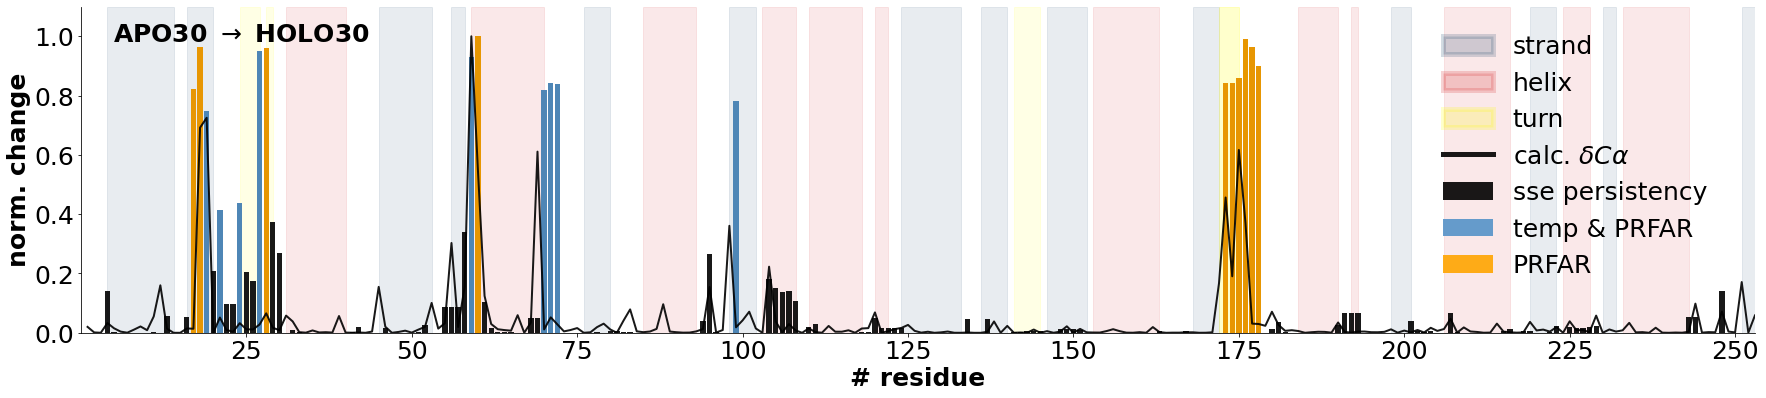

<Figure size 2160x432 with 0 Axes>

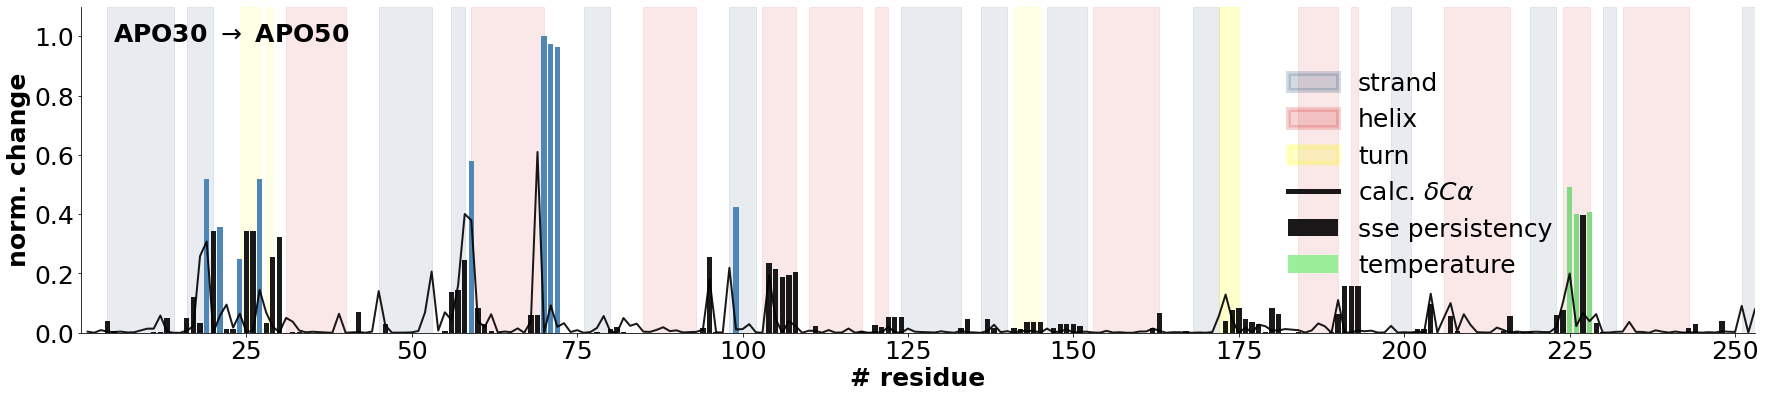

In [37]:
# plot predicted (normalized) delta Calpha shifts along wiht the  
# change in secondary structure persistency in going form APO30 to HOLO30 

fig = plot_canvas()
x = np.arange(len(sse_norm_t30h_t30a))
plt.bar(np.arange(1, len(sse_norm_t30h_t30a)+1),   sse_norm_t30h_t30a, label='sse persistency', color='k', alpha=.9)
plt.plot(np.arange(1, len(norm_SX2_CA_t30h_min_t30a)+1), norm_SX2_CA_t30h_min_t30a, label=r'calc. $\delta C\alpha$',  color='k', alpha=.9)
plt.bar(x[TE]+1, sse_norm_t30h_t30a[TE], color='#5593c8', alpha=.9, label='temp & PRFAR')
plt.bar(x[E]+1, sse_norm_t30h_t30a[E], color='orange',  alpha=.9, label='PRFAR')

xticks=np.arange(0,253,25)[1:]
labels=range(0,253,25)[1:]
plt.xticks(xticks, labels)

plt.xlabel('# residue', weight='bold', fontsize=25)
plt.ylabel('norm. change', weight='bold', fontsize=25)
fig.text(.14, .80, r'APO30 $\rightarrow$ HOLO30', fontsize=25, weight='bold', horizontalalignment='left', color='black')
leg1 = plt.legend(fontsize=25, loc='best', bbox_to_anchor=(.8,.1), framealpha=False)

for legobj in leg1.legendHandles:
    legobj.set_linewidth(5.0)
sns.despine()
#plt.savefig(figpath + 'norm_change_sse_apo30_holo30.pdf', bbox_inches='tight')


# and from APO30 to APO50
fig = plot_canvas()
plt.bar(np.arange(1, len(sse_norm_t50a_t30a)+1),   sse_norm_t50a_t30a, label='sse persistency', color='k', alpha=.9)
plt.plot(np.arange(1, len(norm_SX2_CA_t50a_min_t30a)+1), norm_SX2_CA_t50a_min_t30a, label=r'calc. $\delta C\alpha$',  color='k', alpha=.9)
plt.bar(x[TE]+1, sse_norm_t50a_t30a[TE], color='#5593c8', alpha=.9)
plt.bar(x[T]+1, sse_norm_t50a_t30a[T], color='lightgreen',  alpha=.9, label='temperature')

xticks=np.arange(0,253,25)[1:]
labels=range(0,253,25)[1:]
plt.xticks(xticks, labels)

plt.xlabel('# residue', weight='bold', fontsize=25)
plt.ylabel('norm. change', weight='bold', fontsize=25)

fig.text(.14, .80, r'APO30 $\rightarrow$ APO50', fontsize=25, weight='bold', horizontalalignment='left', color='black')
leg1 = plt.legend(fontsize=25, loc='best', bbox_to_anchor=(.8,.1), framealpha=False)
for legobj in leg1.legendHandles:
    legobj.set_linewidth(5.0)
#plt.savefig(figpath + 'norm_change_sse_apo30_apo50.pdf', bbox_inches='tight')
sns.despine()

print("(TOP) Change in average SHIFTX282 simulated Cα chemical shift (solid black line)"\
      "calculated from apo30 to holo30. Bars represent the change in secondary structure"\
      "element (SSE) persistency for each residue. SSE persistency values are computed as"\
      "the percentage of frames in which each residue retains the secondary structure as"\
      "assigned in the 1GPW crystal structure. (BOTTOM) Analogous to (TOP) but depicting"\
      "the SSE and Cα change occurring from apo30 to apo50.")

(TOP) Change in average SHIFTX282 simulated Cα chemical shift (solid black line)calculated from apo30 to holo30. Bars represent the change in secondary structureelement (SSE) persistency for each residue. SSE persistency values are computed asthe percentage of frames in which each residue retains the secondary structure asassigned in the 1GPW crystal structure. (BOTTOM) Analogous to (TOP) but depictingthe SSE and Cα change occurring from apo30 to apo50.


<Figure size 2160x432 with 0 Axes>

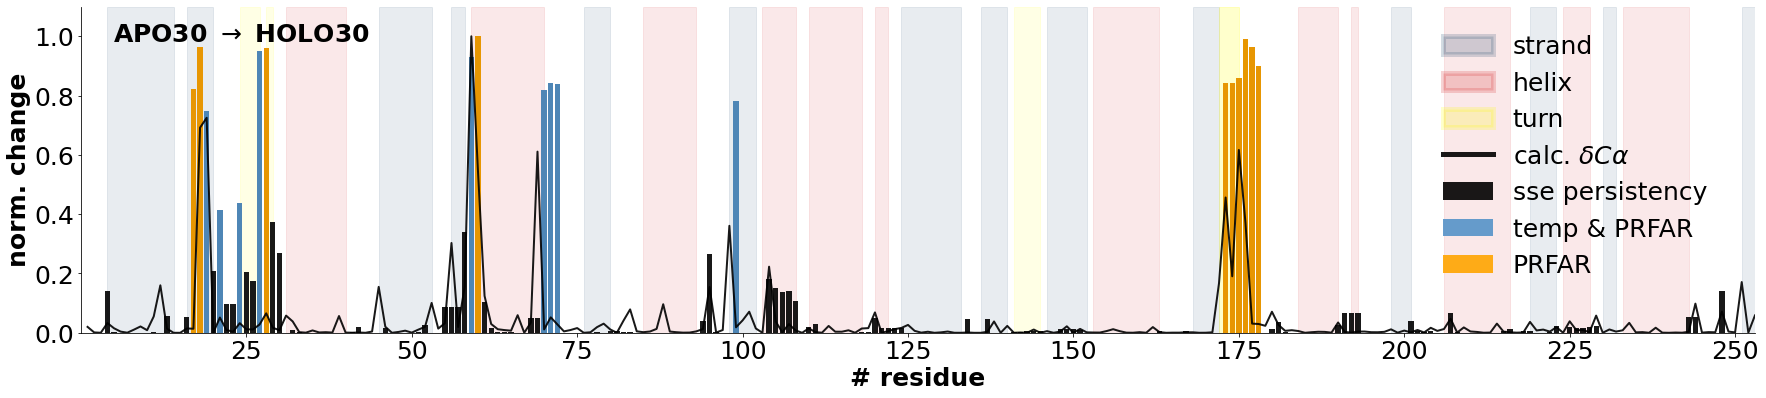

<Figure size 2160x432 with 0 Axes>

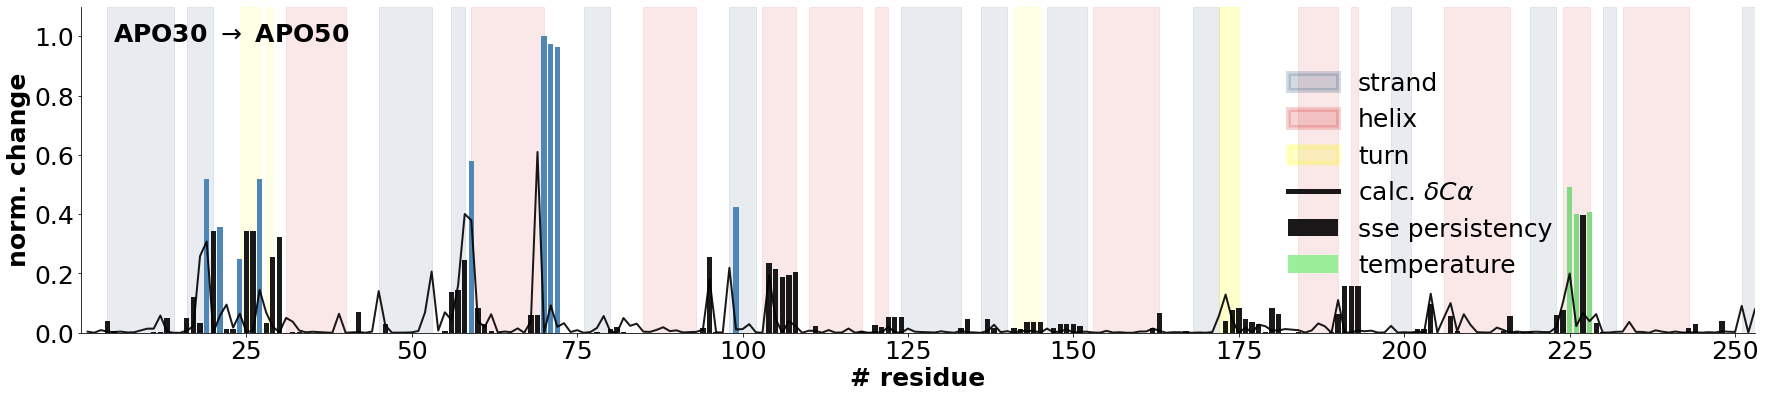

In [40]:
# plot predicted (normalized) delta Calpha shifts along wiht the  
# change in secondary structure persistency in going form APO30 to HOLO30 

fig = plot_canvas()
x = np.arange(len(sse_norm_t30h_t30a))
plt.bar(np.arange(1, len(sse_norm_t30h_t30a)+1),   sse_norm_t30h_t30a, label='sse persistency', color='k', alpha=.9)
plt.plot(np.arange(1, len(norm_SX2_CA_t30h_min_t30a)+1), norm_SX2_CA_t30h_min_t30a, label=r'calc. $\delta C\alpha$',  color='k', alpha=.9)
plt.bar(x[TE]+1, sse_norm_t30h_t30a[TE], color='#5593c8', alpha=.9, label='temp & PRFAR')
plt.bar(x[E]+1, sse_norm_t30h_t30a[E], color='orange',  alpha=.9, label='PRFAR')

xticks=np.arange(0,253,25)[1:]
labels=range(0,253,25)[1:]
plt.xticks(xticks, labels)

plt.xlabel('# residue', weight='bold', fontsize=25)
plt.ylabel('norm. change', weight='bold', fontsize=25)
fig.text(.14, .80, r'APO30 $\rightarrow$ HOLO30', fontsize=25, weight='bold', horizontalalignment='left', color='black')
leg1 = plt.legend(fontsize=25, loc='best', bbox_to_anchor=(.8,.1), framealpha=False)

for legobj in leg1.legendHandles:
    legobj.set_linewidth(5.0)
sns.despine()

df_fig3c = pd.DataFrame()
df_fig3c['AA number'] = np.arange(1, len(sse_norm_t30h_t30a)+1)
df_fig3c['SSE persistency']  = sse_norm_t30h_t30a
df_fig3c['Norm. diff. simulated shift (holo30 minus apo30)']  = sse_norm_t30h_t30a

#plt.savefig(figpath + 'norm_change_sse_apo30_holo30.pdf', bbox_inches='tight')


# and from APO30 to APO50
fig = plot_canvas()
plt.bar(np.arange(1, len(sse_norm_t50a_t30a)+1),   sse_norm_t50a_t30a, label='sse persistency', color='k', alpha=.9)
plt.plot(np.arange(1, len(norm_SX2_CA_t50a_min_t30a)+1), norm_SX2_CA_t50a_min_t30a, label=r'calc. $\delta C\alpha$',  color='k', alpha=.9)
plt.bar(x[TE]+1, sse_norm_t50a_t30a[TE], color='#5593c8', alpha=.9)
plt.bar(x[T]+1, sse_norm_t50a_t30a[T], color='lightgreen',  alpha=.9, label='temperature')

xticks=np.arange(0,253,25)[1:]
labels=range(0,253,25)[1:]
plt.xticks(xticks, labels)

plt.xlabel('# residue', weight='bold', fontsize=25)
plt.ylabel('norm. change', weight='bold', fontsize=25)

fig.text(.14, .80, r'APO30 $\rightarrow$ APO50', fontsize=25, weight='bold', horizontalalignment='left', color='black')
leg1 = plt.legend(fontsize=25, loc='best', bbox_to_anchor=(.8,.1), framealpha=False)
for legobj in leg1.legendHandles:
    legobj.set_linewidth(5.0)
#plt.savefig(figpath + 'norm_change_sse_apo30_apo50.pdf', bbox_inches='tight')
sns.despine()

df_fig3d = pd.DataFrame()
df_fig3d['AA number'] = np.arange(1, len(sse_norm_t50a_t30a)+1)
df_fig3d['SSE persistency']  = sse_norm_t50a_t30a
df_fig3d['Norm. diff. simulated shift (apo50 minus apo30)']  = sse_norm_t50a_t30a

print("(TOP) Change in average SHIFTX282 simulated Cα chemical shift (solid black line)"\
      "calculated from apo30 to holo30. Bars represent the change in secondary structure"\
      "element (SSE) persistency for each residue. SSE persistency values are computed as"\
      "the percentage of frames in which each residue retains the secondary structure as"\
      "assigned in the 1GPW crystal structure. (BOTTOM) Analogous to (TOP) but depicting"\
      "the SSE and Cα change occurring from apo30 to apo50.")

In [43]:
df_fig3d.to_csv('data_figure_3d.csv')

In [44]:
df_fig3c.to_csv('data_figure_3c.csv')